In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import gc
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.calibration import calibration_curve

import torchvision
from torchvision import transforms

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Install required packages for XAI
!pip install -q torchcam captum

from torchcam.methods import GradCAM, GradCAMpp, ScoreCAM
import captum
from captum.attr import IntegratedGradients, Saliency

# --- COMPLETE Configuration ---
class Config:
    DATA_DIR = '/kaggle/input/eurosat-dataset/EuroSAT/'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Training parameters 
    NUM_EPOCHS = 35 
    BATCH_SIZE = 64  
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.05
    LABEL_SMOOTHING = 0.1
    
    # Model parameters 
    IMG_SIZE = 224
    MODEL_ARCH = 'efficientnet_b3'
    USE_ENSEMBLE = True 
    
    # Augmentation parameters 
    USE_CUTMIX = True
    CUTMIX_ALPHA = 1.0
    USE_MIXUP = False
    
    # Scheduler
    SCHEDULER = 'cosine'

    SAVE_CHECKPOINTS = True
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    CHECKPOINT_FREQUENCY = 5  

config = Config()
print(f"Using device: {config.DEVICE}")

# Disk space cleanup
def initial_cleanup():
    import shutil
    if os.path.exists(config.CHECKPOINT_DIR):
        shutil.rmtree(config.CHECKPOINT_DIR)
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    torch.cuda.empty_cache()
    gc.collect()
    print("✓ Disk cleanup completed")

initial_cleanup()

Using device: cuda
✓ Disk cleanup completed


In [4]:
class SatelliteAdvancedAugmentations:
    def __init__(self, img_size=224):
        self.img_size = img_size
       
        self.geometric_transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=180),
            transforms.RandomAffine(
                degrees=15,
                translate=(0.2, 0.2),
                scale=(0.8, 1.2),
                shear=10
            ),
        ])
        
        self.photometric_transforms = transforms.Compose([
            transforms.ColorJitter(
                brightness=0.3,
                contrast=0.3,
                saturation=0.3,
                hue=0.1
            ),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        ])
        
        self.regularization_transforms = transforms.Compose([
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
            transforms.RandomGrayscale(p=0.1),
        ])
        
        self.normalize = transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        )

    def get_train_transforms(self):
        return transforms.Compose([
            self.geometric_transforms,
            self.photometric_transforms,
            transforms.ToTensor(),
            self.regularization_transforms,
            self.normalize
        ])
    
    def get_val_transforms(self):
        return transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            self.normalize
        ])

# CutMix Implementation
def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
        
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Advanced Loss Functions (KEEP)
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.smoothing = smoothing
        self.reduction = reduction
        
    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# Data Preparation
image_paths = glob(os.path.join(config.DATA_DIR, '*/*.jpg'))
all_entries = sorted(os.listdir(config.DATA_DIR))
class_names = [entry for entry in all_entries if os.path.isdir(os.path.join(config.DATA_DIR, entry))]

class_to_idx = {name: i for i, name in enumerate(class_names)}
labels = [class_to_idx[os.path.basename(os.path.dirname(p))] for p in image_paths]

# Split data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

augmentations = SatelliteAdvancedAugmentations(img_size=config.IMG_SIZE)

# Dataset Class
class EuroSATDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Create datasets
train_dataset = EuroSATDataset(train_paths, train_labels, transform=augmentations.get_train_transforms())
val_dataset = EuroSATDataset(val_paths, val_labels, transform=augmentations.get_val_transforms())

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Found {len(class_names)} classes: {class_names}")

Training samples: 21600, Validation samples: 5400
Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Calculating image statistics:   0%|          | 0/21600 [00:00<?, ?it/s]

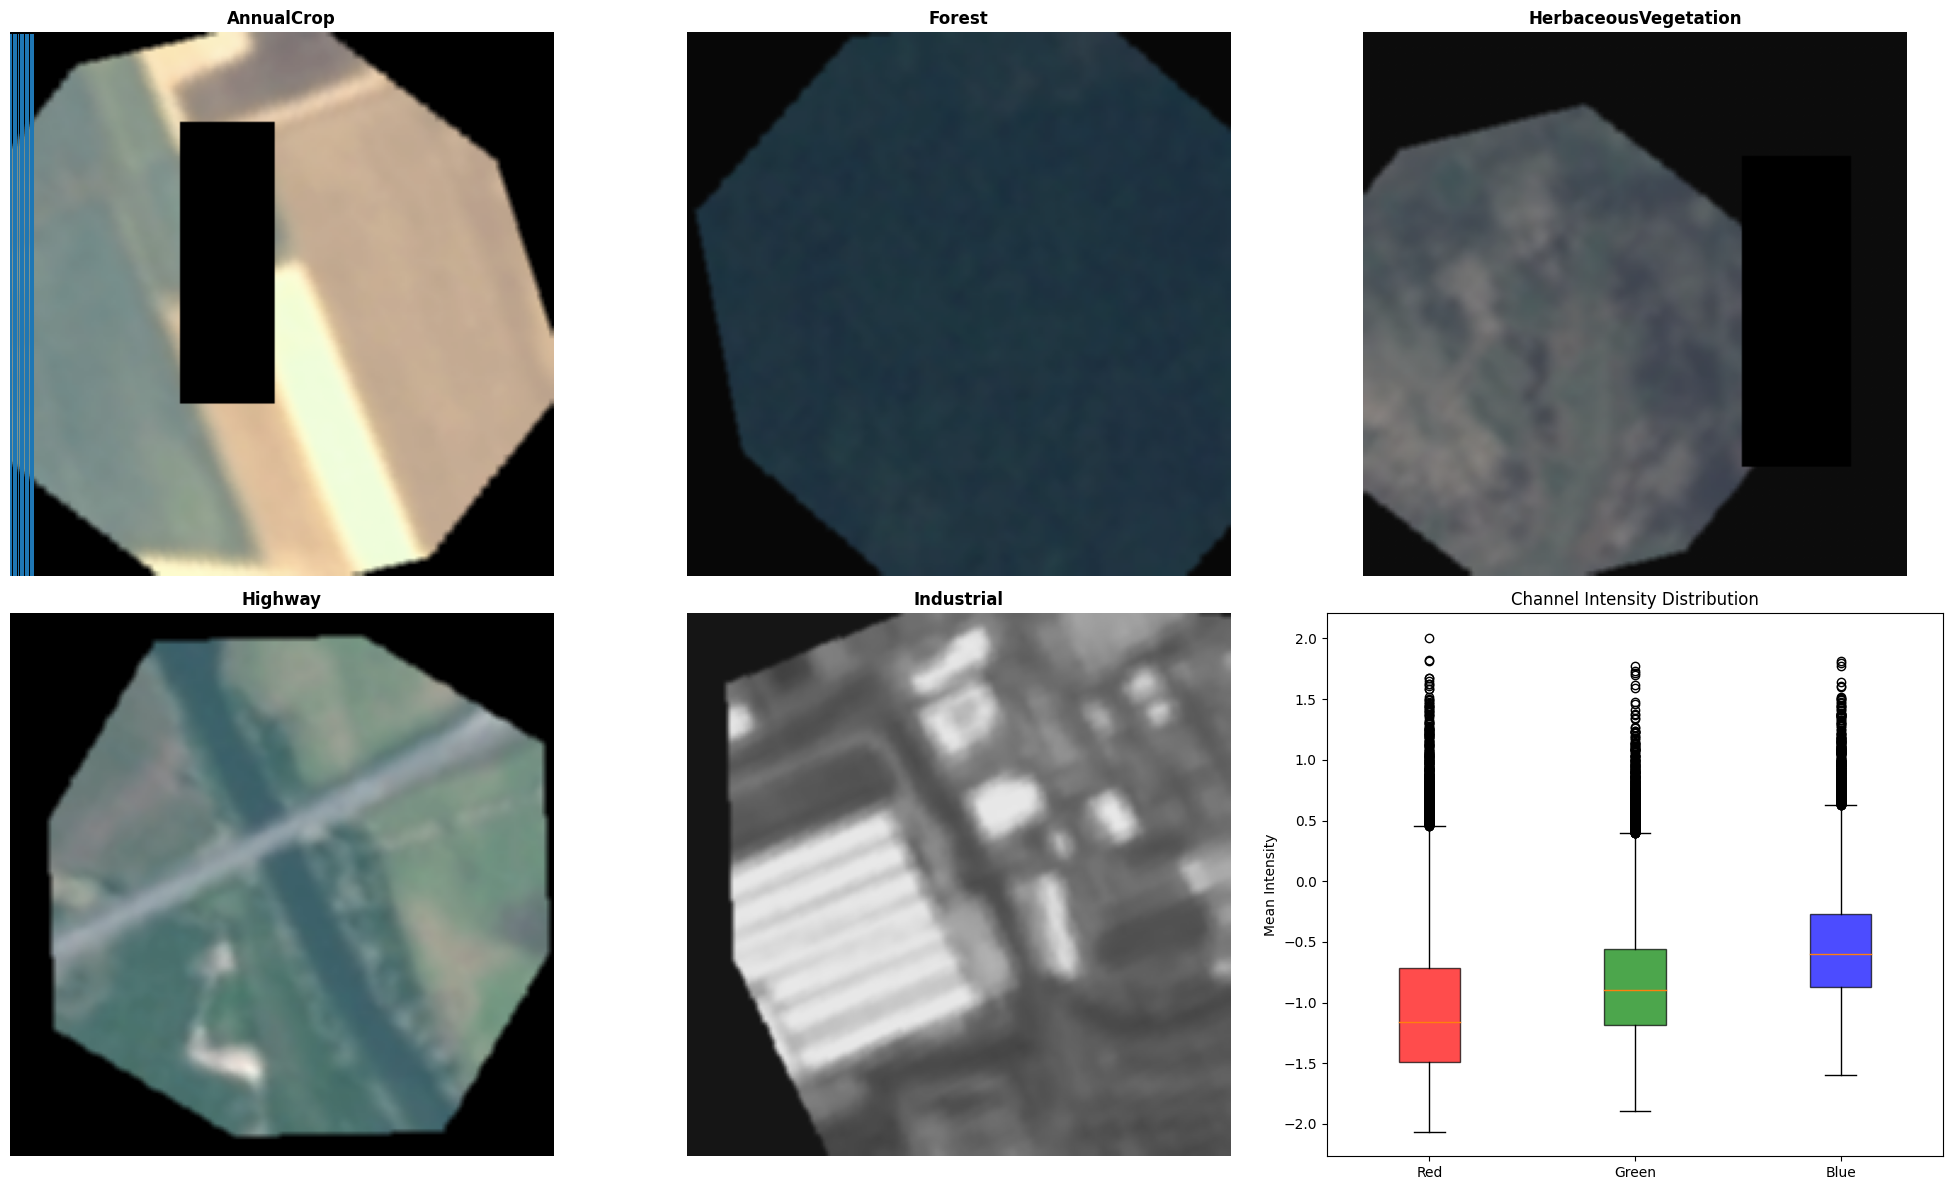

=== Dataset Statistics ===
Total samples: 21600
Number of classes: 10
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
def comprehensive_eda(dataset, class_names, labels):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Class distribution
    class_counts = pd.Series([class_names[l] for l in labels]).value_counts()
    axes[0,0].bar(class_counts.index, class_counts.values)
    axes[0,0].set_title('Class Distribution', fontsize=14, fontweight='bold')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Sample images from each class - FIXED INDEXING
    unique_classes = np.unique(labels)
    sample_indices = []
    
    # Get one sample from each of the first 6 classes
    for class_idx in unique_classes[:6]:
        class_samples = [idx for idx, label in enumerate(labels) if label == class_idx]
        sample_idx = np.random.choice(class_samples)
        sample_indices.append((sample_idx, class_idx))
    
    # Plot the samples with proper indexing
    for i, (sample_idx, class_idx) in enumerate(sample_indices):
        row = 1 if i >= 3 else 0
        col = i % 3
        
        img, label = dataset[sample_idx]
        
        # Denormalize
        img_denorm = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        axes[row, col].imshow(img_denorm.permute(1, 2, 0))
        axes[row, col].set_title(f'{class_names[label]}', fontweight='bold')
        axes[row, col].axis('off')
    
    # Image statistics
    mean_r, mean_g, mean_b = [], [], []
    
    for img, _ in tqdm(dataset, desc="Calculating image statistics"):
        mean_r.append(img[0].mean().item())
        mean_g.append(img[1].mean().item())
        mean_b.append(img[2].mean().item())
    
    # Remove empty subplot and add statistics
    axes[1, 2].remove()
    ax_stats = fig.add_subplot(2, 3, 6)
    
    colors = ['red', 'green', 'blue']
    channel_data = [mean_r, mean_g, mean_b]
    channel_names = ['Red', 'Green', 'Blue']
    
    bp = ax_stats.boxplot(channel_data, labels=channel_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax_stats.set_title('Channel Intensity Distribution')
    ax_stats.set_ylabel('Mean Intensity')
    
    plt.tight_layout()
    plt.show()
    
    print("=== Dataset Statistics ===")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")
    
    return {
        'class_distribution': class_counts,
        'channel_means': {'R': np.mean(mean_r), 'G': np.mean(mean_g), 'B': np.mean(mean_b)}
    }

eda_results = comprehensive_eda(train_dataset, class_names, train_labels)

In [6]:
class AdvancedModelFactory:
    @staticmethod
    def get_model(model_name, num_classes=10, pretrained=True):
        if model_name == 'efficientnet_b3':
            model = torchvision.models.efficientnet_b3(
                weights=torchvision.models.EfficientNet_B3_Weights.DEFAULT if pretrained else None
            )
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, num_classes)
            
        elif model_name == 'convnext_tiny':
            model = torchvision.models.convnext_tiny(
                weights=torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
            )
            in_features = model.classifier[2].in_features
            model.classifier[2] = nn.Linear(in_features, num_classes)
            
        elif model_name == 'resnet50':
            model = torchvision.models.resnet50(
                weights=torchvision.models.ResNet50_Weights.DEFAULT if pretrained else None
            )
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, num_classes)
            
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        return model
    
    @staticmethod
    def create_heterogeneous_ensemble(num_classes=10):
        """Create ensemble of different architectures"""
        models = []
        architectures = ['efficientnet_b3', 'convnext_tiny', 'resnet50']
        
        for arch in architectures:
            model = AdvancedModelFactory.get_model(arch, num_classes)
            models.append(model)
            
        return HeterogeneousEnsemble(models, num_classes)

class HeterogeneousEnsemble(nn.Module):
    """Advanced ensemble with learnable weights"""
    def __init__(self, models, num_classes=10):
        super().__init__()
        self.models = nn.ModuleList(models)
        
        # Learnable ensemble weights
        self.ensemble_weights = nn.Parameter(torch.ones(len(models)))
        
    def forward(self, x):
        outputs = []
        for model in self.models:
            outputs.append(model(x))
        
        # Weighted ensemble
        weights = F.softmax(self.ensemble_weights, dim=0)
        ensemble_output = sum(w * out for w, out in zip(weights, outputs))
        
        return ensemble_output

# Model initialization
if config.USE_ENSEMBLE:
    model = AdvancedModelFactory.create_heterogeneous_ensemble(num_classes=len(class_names))
    print("Using Heterogeneous Ensemble")
else:
    model = AdvancedModelFactory.get_model(config.MODEL_ARCH, num_classes=len(class_names))
    print(f"Using {config.MODEL_ARCH}")

model = model.to(config.DEVICE)
print(f"Model initialized on {config.DEVICE}")

Using Heterogeneous Ensemble
Model initialized on cuda


In [7]:
# Training Components with Memory Optimization

class CheckpointManager:
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(checkpoint_dir, exist_ok=True)
        self.best_accuracy = 0.0
        
    def save_checkpoint(self, model, optimizer, scheduler, epoch, metrics, is_best=False, frequency=5):
        if not is_best and epoch % frequency != 0:
            return
            
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'metrics': metrics,
            'timestamp': datetime.now().isoformat(),
        }
        
        if is_best:
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['scheduler_state_dict'] = scheduler.state_dict() if scheduler else None
        
        filename = f'checkpoint_epoch_{epoch:03d}.pth'
        if is_best:
            filename = 'best_model.pth'
            
        torch.save(checkpoint, os.path.join(self.checkpoint_dir, filename))
        
        self._clean_old_checkpoints(keep_last=3)
        
    def _clean_old_checkpoints(self, keep_last=3):
        import glob
        checkpoints = glob.glob(os.path.join(self.checkpoint_dir, 'checkpoint_epoch_*.pth'))
        if len(checkpoints) > keep_last:
            checkpoints.sort(key=os.path.getmtime)
            for old_checkpoint in checkpoints[:-keep_last]:
                os.remove(old_checkpoint)

class ExperimentTracker:
    def __init__(self, experiment_name):
        self.experiment_name = experiment_name
        self.metrics_history = {
            'train_loss': [], 'val_loss': [], 
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }
        self.best_epoch = 0
        self.best_accuracy = 0.0
        
    def log_metrics(self, metrics_dict, epoch):
        for key, value in metrics_dict.items():
            if key in self.metrics_history:
                self.metrics_history[key].append(value)
        
        if metrics_dict['val_acc'] > self.best_accuracy:
            self.best_accuracy = metrics_dict['val_acc']
            self.best_epoch = epoch

class TrainingComponents:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        
        self.criterion = LabelSmoothingCrossEntropy(smoothing=config.LABEL_SMOOTHING)
        
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=1, eta_min=1e-6
        )
        
        self.use_amp = True
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)

class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        
        self.components = TrainingComponents(model, config)
        self.tracker = ExperimentTracker("eurosat_training")
        self.checkpoint_manager = CheckpointManager(config.CHECKPOINT_DIR)
        
        self.best_val_acc = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        torch.cuda.empty_cache()
        gc.collect()
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch:02d}')
        
        for batch_idx, (images, targets) in enumerate(pbar):
            try:
                images, targets = images.to(config.DEVICE, non_blocking=True), targets.to(config.DEVICE, non_blocking=True)
                
                use_cutmix = self.config.USE_CUTMIX and np.random.random() < 0.3
                if use_cutmix:
                    images, targets_a, targets_b, lam = cutmix_data(images, targets, self.config.CUTMIX_ALPHA)
                
                self.components.optimizer.zero_grad()
                
                if self.components.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(images)
                        
                        if use_cutmix:
                            loss = (lam * self.components.criterion(outputs, targets_a) + 
                                   (1 - lam) * self.components.criterion(outputs, targets_b))
                        else:
                            loss = self.components.criterion(outputs, targets)
                    
                    self.components.scaler.scale(loss).backward()
                    self.components.scaler.step(self.components.optimizer)
                    self.components.scaler.update()
                else:
                    outputs = self.model(images)
                    
                    if use_cutmix:
                        loss = (lam * self.components.criterion(outputs, targets_a) + 
                               (1 - lam) * self.components.criterion(outputs, targets_b))
                    else:
                        loss = self.components.criterion(outputs, targets)
                    
                    loss.backward()
                    self.components.optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_samples += targets.size(0)
                
                if use_cutmix:
                    correct_predictions += (lam * predicted.eq(targets_a).sum().item() + 
                                          (1 - lam) * predicted.eq(targets_b).sum().item())
                else:
                    correct_predictions += predicted.eq(targets).sum().item()
                
                if batch_idx % 50 == 0:
                    current_acc = 100. * correct_predictions / total_samples
                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.2f}%',
                        'AMP': f'{self.components.use_amp}'
                    })
                    
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM at batch {batch_idx}. Cleaning up and continuing...")
                    torch.cuda.empty_cache()
                    gc.collect()
                    continue
                else:
                    raise e
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct_predictions / total_samples
        
        return epoch_loss, epoch_acc
    
    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():
            for images, targets in tqdm(self.val_loader, desc='Validation'):
                images, targets = images.to(config.DEVICE, non_blocking=True), targets.to(config.DEVICE, non_blocking=True)
                
                outputs = self.model(images)
                loss = self.components.criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_samples += targets.size(0)
                correct_predictions += predicted.eq(targets).sum().item()
                
                if total_samples % 1000 == 0:
                    torch.cuda.empty_cache()
        
        val_loss = running_loss / len(self.val_loader)
        val_acc = 100. * correct_predictions / total_samples
        
        return val_loss, val_acc
    
    def train(self):
        print("Starting training with memory optimization...")
        print(f"Using Mixed Precision: {self.components.use_amp}")
        print(f"Model: {'Ensemble' if config.USE_ENSEMBLE else config.MODEL_ARCH}")
        
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**3
            cached = torch.cuda.memory_reserved() / 1024**3
            print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB")
        
        start_time = datetime.now()
        
        for epoch in range(1, self.config.NUM_EPOCHS + 1):
            epoch_start = datetime.now()
            
            try:
                train_loss, train_acc = self.train_epoch(epoch)
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM during training epoch {epoch}. Disabling mixed precision and retrying...")
                    self.components.use_amp = False
                    self.components.scaler = torch.cuda.amp.GradScaler(enabled=False)
                    torch.cuda.empty_cache()
                    gc.collect()
                    train_loss, train_acc = self.train_epoch(epoch)
                else:
                    raise e
            
            val_loss, val_acc = self.validate_epoch()
            
            self.components.scheduler.step()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            metrics = {
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'learning_rate': self.components.optimizer.param_groups[0]['lr']
            }
            self.tracker.log_metrics(metrics, epoch)
            
            is_best = val_acc > self.best_val_acc
            if is_best:
                self.best_val_acc = val_acc
                
            if self.config.SAVE_CHECKPOINTS:
                self.checkpoint_manager.save_checkpoint(
                    self.model, self.components.optimizer, self.components.scheduler,
                    epoch, {'val_acc': val_acc, 'val_loss': val_loss},
                    is_best, self.config.CHECKPOINT_FREQUENCY
                )
            
            epoch_time = (datetime.now() - epoch_start).total_seconds()
            current_lr = self.components.optimizer.param_groups[0]['lr']
            
            print(f'Epoch {epoch:02d}/{self.config.NUM_EPOCHS} | '
                  f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}% | '
                  f'Best: {self.best_val_acc:.2f}% | '
                  f'LR: {current_lr:.2e} | '
                  f'Time: {epoch_time:.1f}s')
            
            if epoch >= 15:
                recent_epochs = 8
                if len(self.history['val_acc']) >= recent_epochs:
                    recent_acc = self.history['val_acc'][-recent_epochs:]
                    best_recent = max(recent_acc)
                    if best_recent <= self.history['val_acc'][-recent_epochs]:
                        print(f"Early stopping at epoch {epoch} - no improvement in last {recent_epochs} epochs")
                        break
            
            torch.cuda.empty_cache()
            gc.collect()
        
        total_time = (datetime.now() - start_time).total_seconds() / 60
        print(f"Training completed in {total_time:.1f} minutes")
        print(f"Best validation accuracy: {self.best_val_acc:.2f}%")
        
        return self.history

def get_safe_model(num_classes):
    try:
        if config.USE_ENSEMBLE:
            print("Initializing ensemble model...")
            model = AdvancedModelFactory.create_heterogeneous_ensemble(num_classes=num_classes)
            print("Ensemble model loaded successfully")
        else:
            model = AdvancedModelFactory.get_model(config.MODEL_ARCH, num_classes=num_classes)
            print(f"Single model ({config.MODEL_ARCH}) loaded successfully")
        return model
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("OOM with ensemble. Falling back to single model...")
            config.USE_ENSEMBLE = False
            model = AdvancedModelFactory.get_model(config.MODEL_ARCH, num_classes=num_classes)
            print(f"Fallback to single model ({config.MODEL_ARCH})")
            return model
        else:
            raise e

print("Initializing model with memory safety...")
model = get_safe_model(len(class_names))
model = model.to(config.DEVICE)

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated() / 1024**3
    cached = torch.cuda.memory_reserved() / 1024**3
    print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB")

print("Starting training...")
trainer = Trainer(model, train_loader, val_loader, config)
history = trainer.train()

Initializing model with memory safety...
Initializing ensemble model...
Ensemble model loaded successfully
GPU Memory - Allocated: 0.23 GB, Cached: 0.26 GB
Starting training...
Starting training with memory optimization...
Using Mixed Precision: True
Model: Ensemble
GPU Memory - Allocated: 0.23 GB, Cached: 0.26 GB


Epoch 01:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 01/35 | Train Loss: 0.9728, Acc: 80.46% | Val Loss: 0.6271, Acc: 95.94% | Best: 95.94% | LR: 9.76e-04 | Time: 362.3s


Epoch 02:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 02/35 | Train Loss: 0.8298, Acc: 86.12% | Val Loss: 0.6470, Acc: 94.33% | Best: 95.94% | LR: 9.05e-04 | Time: 358.7s


Epoch 03:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 03/35 | Train Loss: 0.8244, Acc: 85.70% | Val Loss: 0.6005, Acc: 96.52% | Best: 96.52% | LR: 7.94e-04 | Time: 369.5s


Epoch 04:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 04/35 | Train Loss: 0.7652, Acc: 88.71% | Val Loss: 0.6053, Acc: 95.74% | Best: 96.52% | LR: 6.55e-04 | Time: 357.4s


Epoch 05:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 05/35 | Train Loss: 0.7582, Acc: 88.58% | Val Loss: 0.5739, Acc: 97.09% | Best: 97.09% | LR: 5.01e-04 | Time: 369.3s


Epoch 06:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 06/35 | Train Loss: 0.7350, Acc: 89.37% | Val Loss: 0.5544, Acc: 98.11% | Best: 98.11% | LR: 3.46e-04 | Time: 368.8s


Epoch 07:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 07/35 | Train Loss: 0.7087, Acc: 90.54% | Val Loss: 0.5463, Acc: 98.30% | Best: 98.30% | LR: 2.07e-04 | Time: 369.6s


Epoch 08:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 08/35 | Train Loss: 0.7346, Acc: 88.80% | Val Loss: 0.5544, Acc: 97.89% | Best: 98.30% | LR: 9.64e-05 | Time: 358.5s


Epoch 09:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 09/35 | Train Loss: 0.7371, Acc: 88.15% | Val Loss: 0.5543, Acc: 98.06% | Best: 98.30% | LR: 2.54e-05 | Time: 357.3s


Epoch 10:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10/35 | Train Loss: 0.6912, Acc: 90.83% | Val Loss: 0.5474, Acc: 98.15% | Best: 98.30% | LR: 1.00e-03 | Time: 367.3s


Epoch 11:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11/35 | Train Loss: 0.8241, Acc: 85.59% | Val Loss: 0.6551, Acc: 94.15% | Best: 98.30% | LR: 9.76e-04 | Time: 355.4s


Epoch 12:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12/35 | Train Loss: 0.7733, Acc: 87.87% | Val Loss: 0.6061, Acc: 95.37% | Best: 98.30% | LR: 9.05e-04 | Time: 354.2s


Epoch 13:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13/35 | Train Loss: 0.7866, Acc: 86.70% | Val Loss: 0.6264, Acc: 94.54% | Best: 98.30% | LR: 7.94e-04 | Time: 354.4s


Epoch 14:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14/35 | Train Loss: 0.7474, Acc: 88.57% | Val Loss: 0.5828, Acc: 96.93% | Best: 98.30% | LR: 6.55e-04 | Time: 354.0s


Epoch 15:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15/35 | Train Loss: 0.7604, Acc: 87.63% | Val Loss: 0.5607, Acc: 97.61% | Best: 98.30% | LR: 5.01e-04 | Time: 364.3s


Epoch 16:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 16/35 | Train Loss: 0.7397, Acc: 88.59% | Val Loss: 0.5515, Acc: 98.00% | Best: 98.30% | LR: 3.46e-04 | Time: 352.5s


Epoch 17:   0%|          | 0/338 [00:00<?, ?it/s]

Validation:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 17/35 | Train Loss: 0.7155, Acc: 89.72% | Val Loss: 0.5730, Acc: 96.93% | Best: 98.30% | LR: 2.07e-04 | Time: 353.2s
Early stopping at epoch 17 - no improvement in last 8 epochs
Training completed in 106.4 minutes
Best validation accuracy: 98.30%


Running Comprehensive Evaluation...
=== COMPREHENSIVE MODEL EVALUATION ===


Calculating metrics:   0%|          | 0/85 [00:00<?, ?it/s]

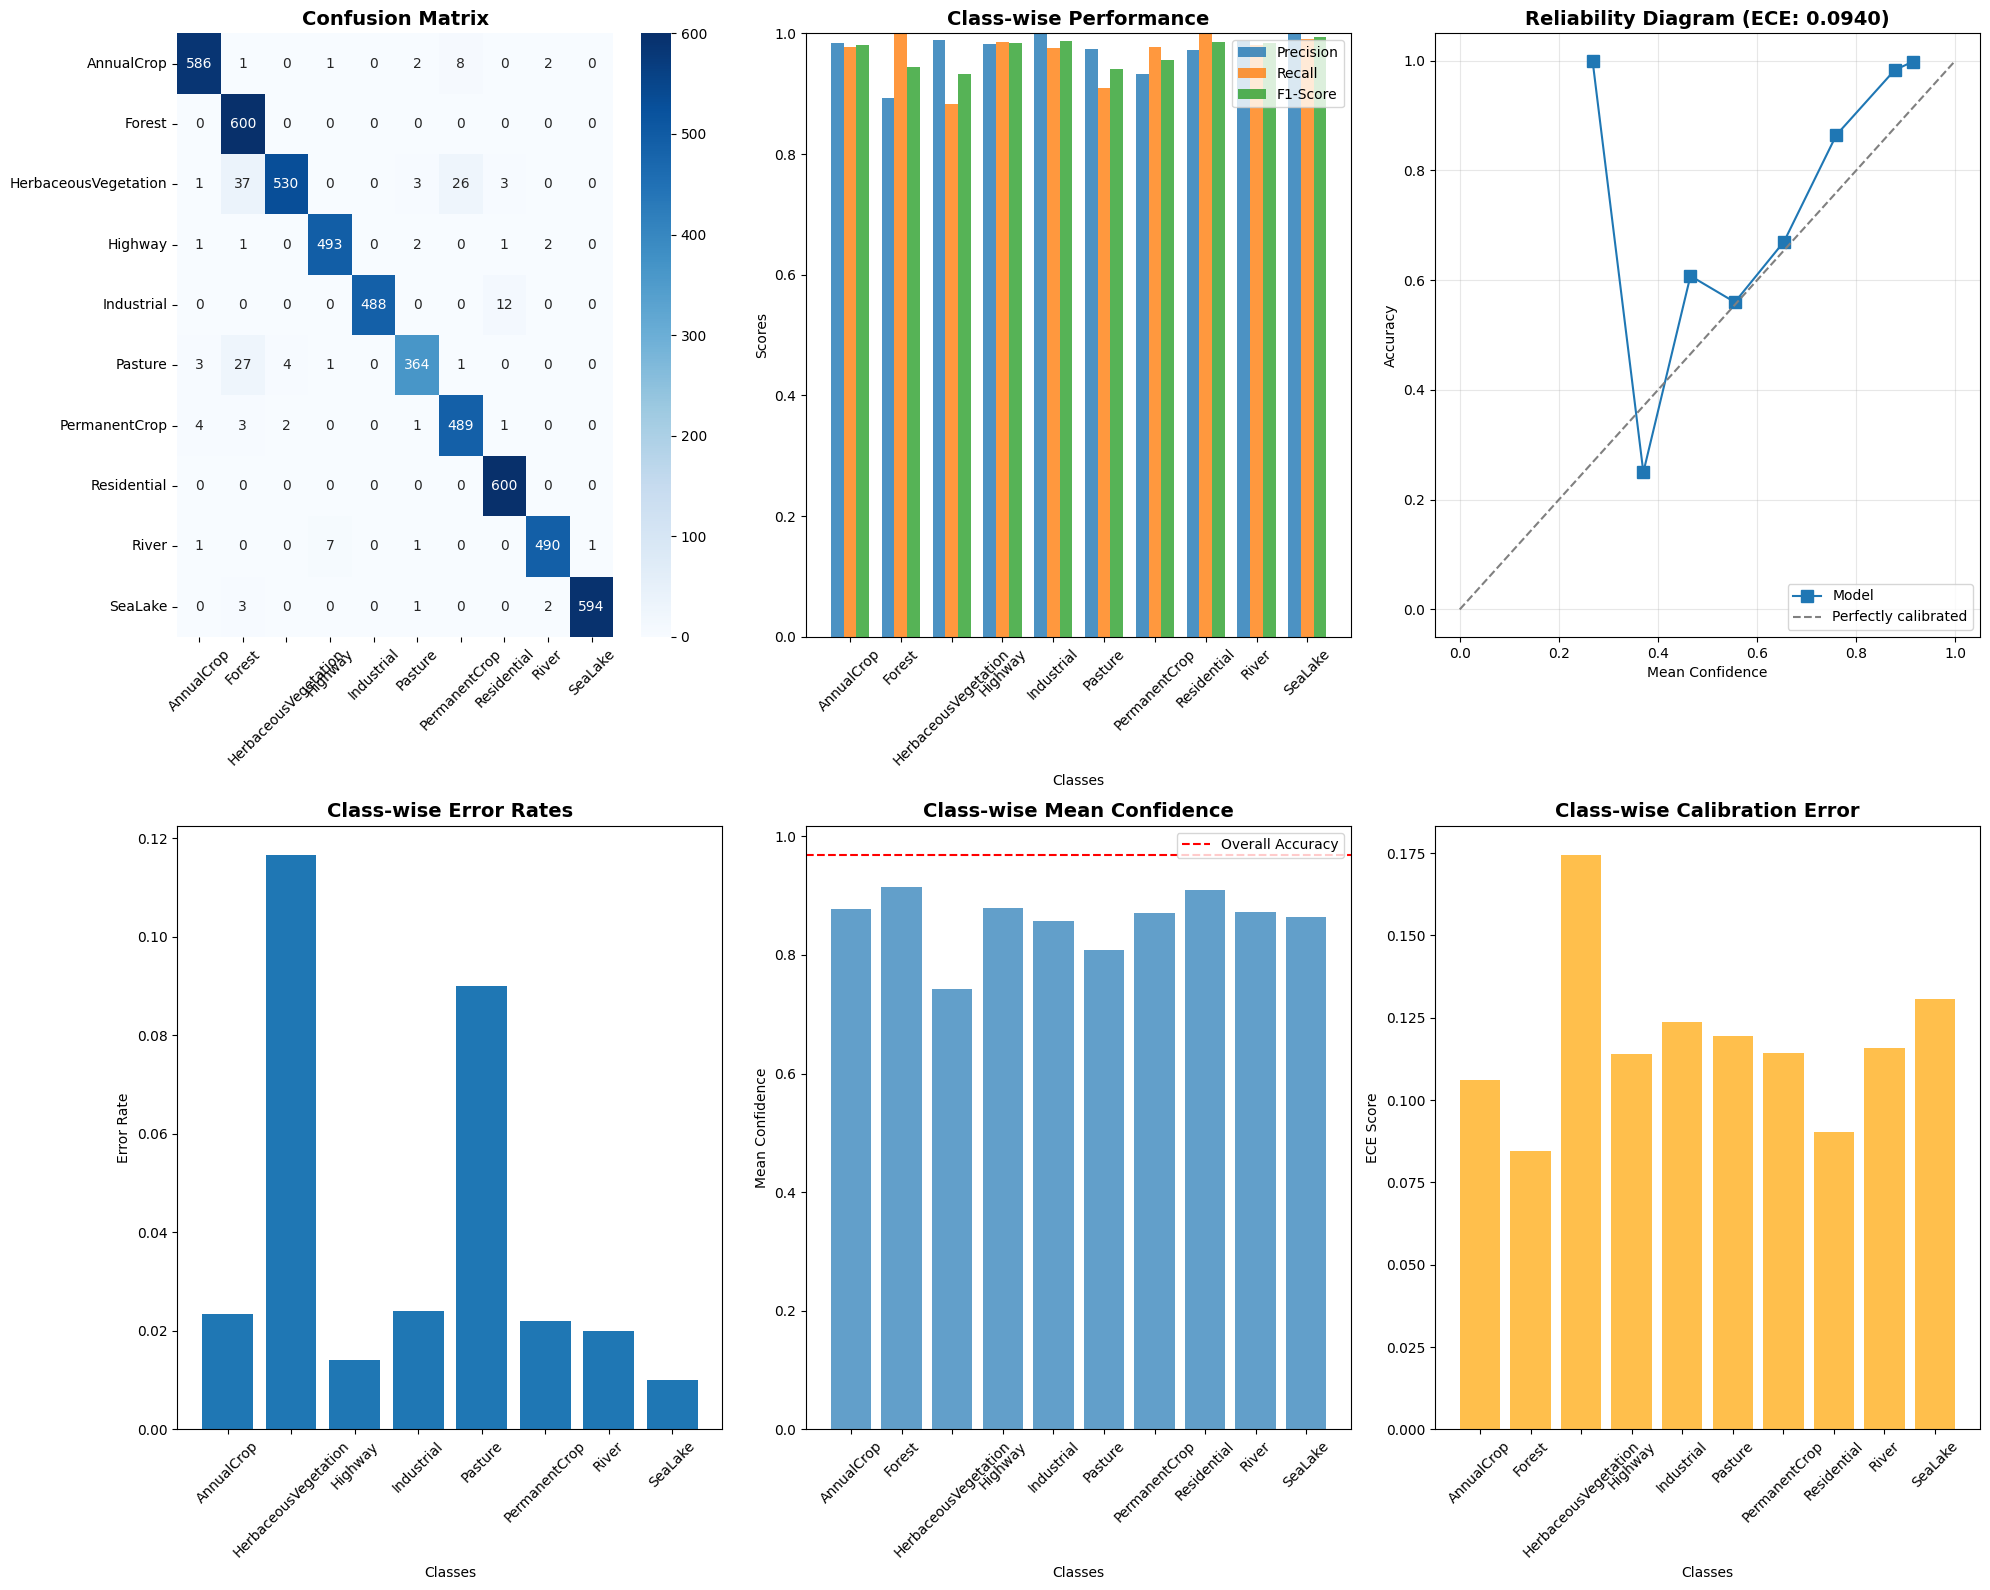


COMPREHENSIVE EVALUATION SUMMARY
Overall Accuracy: 0.9693
Macro F1-Score: 0.9688
Expected Calibration Error: 0.0940
Mean Confidence: 0.8756
Mean Accuracy: 0.9693
Model is UNDERCONFIDENT

TOP 3 PERFORMING CLASSES:
  SeaLake                   F1: 0.994
  Industrial                F1: 0.988
  Residential               F1: 0.986

BOTTOM 3 PERFORMING CLASSES:
  HerbaceousVegetation      F1: 0.933
  Pasture                   F1: 0.941
  Forest                    F1: 0.943


In [8]:
class ComprehensiveModelEvaluator:
    def __init__(self, model, val_loader, class_names, device):
        self.model = model
        self.val_loader = val_loader
        self.class_names = class_names
        self.device = device
        self.standard_metrics = None
        
    def comprehensive_evaluation(self):
        print("=== COMPREHENSIVE MODEL EVALUATION ===")
        
        results = {}
        
        # Standard metrics
        results['standard_metrics'] = self._calculate_standard_metrics()
        self.standard_metrics = results['standard_metrics']
        
        # Advanced metrics
        results['confidence_calibration'] = self._evaluate_calibration_multiclass()
        results['class_wise_performance'] = self._class_wise_analysis()
        results['misclassification_analysis'] = self._analyze_misclassifications()
        
        self._generate_comprehensive_report(results)
        
        return results
    
    def _calculate_standard_metrics(self):
        self.model.eval()
        all_preds = []
        all_targets = []
        all_probabilities = []
        
        with torch.no_grad():
            for images, targets in tqdm(self.val_loader, desc="Calculating metrics"):
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images)
                probabilities = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
        
        # Classification report
        clf_report = classification_report(all_targets, all_preds, 
                                         target_names=self.class_names, output_dict=True)
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        
        return {
            'classification_report': clf_report,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'targets': all_targets,
            'probabilities': all_probabilities
        }
    
    def _evaluate_calibration_multiclass(self):
        """FIXED: Multi-class calibration evaluation"""
        probs = np.array(self.standard_metrics['probabilities'])
        targets = np.array(self.standard_metrics['targets'])
        
        # Multi-class Expected Calibration Error
        n_bins = 10
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        confidences = np.max(probs, axis=1)
        predictions = np.argmax(probs, axis=1)
        accuracies = predictions == targets
        
        ece = 0.0
        reliability_data = []
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
            prop_in_bin = np.mean(in_bin)
            
            if prop_in_bin > 0:
                accuracy_in_bin = np.mean(accuracies[in_bin])
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
                reliability_data.append({
                    'confidence': avg_confidence_in_bin,
                    'accuracy': accuracy_in_bin,
                    'samples': np.sum(in_bin)
                })
        
        # Calculate class-wise calibration
        class_calibration = {}
        for class_idx in range(len(self.class_names)):
            class_probs = probs[targets == class_idx]
            if len(class_probs) > 0:
                class_confidences = class_probs[:, class_idx]
                class_accuracies = (np.argmax(class_probs, axis=1) == class_idx).astype(float)
                
                if len(class_confidences) > n_bins:
                    class_ece = 0.0
                    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                        in_bin = np.logical_and(class_confidences > bin_lower, class_confidences <= bin_upper)
                        if np.sum(in_bin) > 0:
                            bin_acc = np.mean(class_accuracies[in_bin])
                            bin_conf = np.mean(class_confidences[in_bin])
                            bin_weight = np.sum(in_bin) / len(class_confidences)
                            class_ece += np.abs(bin_conf - bin_acc) * bin_weight
                    
                    class_calibration[self.class_names[class_idx]] = class_ece
        
        return {
            'ece': ece,
            'reliability_data': reliability_data,
            'class_calibration': class_calibration,
            'mean_confidence': np.mean(confidences),
            'mean_accuracy': np.mean(accuracies)
        }
    
    def _class_wise_analysis(self):
        """Detailed analysis per class"""
        targets = self.standard_metrics['targets']
        predictions = self.standard_metrics['predictions']
        probs = np.array(self.standard_metrics['probabilities'])
        
        class_metrics = {}
        for class_idx, class_name in enumerate(self.class_names):
            class_mask = np.array(targets) == class_idx
            pred_mask = np.array(predictions) == class_idx
            
            if np.sum(class_mask) > 0:
                precision = precision_recall_fscore_support(
                    targets, predictions, labels=[class_idx], average=None
                )[0][0]
                recall = precision_recall_fscore_support(
                    targets, predictions, labels=[class_idx], average=None
                )[1][0]
                f1 = precision_recall_fscore_support(
                    targets, predictions, labels=[class_idx], average=None
                )[2][0]
                
                # Class-wise confidence statistics
                class_confidences = probs[class_mask][:, class_idx]
                mean_confidence = np.mean(class_confidences) if len(class_confidences) > 0 else 0
                std_confidence = np.std(class_confidences) if len(class_confidences) > 0 else 0
                
                class_metrics[class_name] = {
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'support': np.sum(class_mask),
                    'mean_confidence': mean_confidence,
                    'std_confidence': std_confidence
                }
        
        return class_metrics
    
    def _analyze_misclassifications(self):
        """Analyze patterns in misclassifications"""
        cm = self.standard_metrics['confusion_matrix']
        misclassification_patterns = {}
        
        for i in range(len(self.class_names)):
            total = np.sum(cm[i, :])
            correct = cm[i, i]
            misclassified = total - correct
            
            if misclassified > 0:
                # Find most common misclassification
                cm_row = cm[i, :].copy()
                cm_row[i] = 0  # Remove correct predictions
                most_common_misclass = np.argmax(cm_row)
                most_common_count = cm_row[most_common_misclass]
                
                # Find all misclassifications
                error_distribution = {}
                for j in range(len(self.class_names)):
                    if j != i and cm[i, j] > 0:
                        error_distribution[self.class_names[j]] = cm[i, j]
                
                misclassification_patterns[self.class_names[i]] = {
                    'error_rate': misclassified / total,
                    'most_common_error': self.class_names[most_common_misclass],
                    'most_common_error_count': most_common_count,
                    'total_errors': misclassified,
                    'error_distribution': error_distribution
                }
        
        return misclassification_patterns
    
    def _generate_comprehensive_report(self, results):
        """Generate visual comprehensive report"""
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Confusion Matrix
        plt.subplot(2, 3, 1)
        cm = results['standard_metrics']['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        # 2. Class-wise Performance
        plt.subplot(2, 3, 2)
        class_metrics = results['class_wise_performance']
        classes = list(class_metrics.keys())
        precisions = [class_metrics[cls]['precision'] for cls in classes]
        recalls = [class_metrics[cls]['recall'] for cls in classes]
        f1_scores = [class_metrics[cls]['f1_score'] for cls in classes]
        
        x = np.arange(len(classes))
        width = 0.25
        
        plt.bar(x - width, precisions, width, label='Precision', alpha=0.8)
        plt.bar(x, recalls, width, label='Recall', alpha=0.8)
        plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
        
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.title('Class-wise Performance', fontsize=14, fontweight='bold')
        plt.xticks(x, classes, rotation=45)
        plt.legend()
        plt.ylim(0, 1)
        
        # 3. Reliability Diagram (FIXED for multi-class)
        plt.subplot(2, 3, 3)
        reliability_data = results['confidence_calibration']['reliability_data']
        if reliability_data:
            confidences = [item['confidence'] for item in reliability_data]
            accuracies = [item['accuracy'] for item in reliability_data]
            plt.plot(confidences, accuracies, 's-', label='Model', markersize=8)
            plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfectly calibrated')
            plt.xlabel('Mean Confidence')
            plt.ylabel('Accuracy')
            plt.title(f'Reliability Diagram (ECE: {results["confidence_calibration"]["ece"]:.4f})', 
                     fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Reliability Data\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Reliability Diagram', fontsize=14, fontweight='bold')
        
        # 4. Misclassification Analysis
        plt.subplot(2, 3, 4)
        misclass = results['misclassification_analysis']
        if misclass:
            error_rates = [misclass[cls]['error_rate'] for cls in misclass.keys()]
            plt.bar(range(len(misclass)), error_rates)
            plt.xlabel('Classes')
            plt.ylabel('Error Rate')
            plt.title('Class-wise Error Rates', fontsize=14, fontweight='bold')
            plt.xticks(range(len(misclass)), list(misclass.keys()), rotation=45)
        else:
            plt.text(0.5, 0.5, 'No Misclassifications\nFound', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Class-wise Error Rates', fontsize=14, fontweight='bold')
        
        # 5. Class-wise Confidence
        plt.subplot(2, 3, 5)
        class_metrics = results['class_wise_performance']
        classes = list(class_metrics.keys())
        mean_confidences = [class_metrics[cls]['mean_confidence'] for cls in classes]
        
        plt.bar(range(len(classes)), mean_confidences, alpha=0.7)
        plt.axhline(y=results['confidence_calibration']['mean_accuracy'], 
                   color='red', linestyle='--', label='Overall Accuracy')
        plt.xlabel('Classes')
        plt.ylabel('Mean Confidence')
        plt.title('Class-wise Mean Confidence', fontsize=14, fontweight='bold')
        plt.xticks(range(len(classes)), classes, rotation=45)
        plt.legend()
        
        # 6. Calibration by Class
        plt.subplot(2, 3, 6)
        class_calibration = results['confidence_calibration']['class_calibration']
        if class_calibration:
            classes_cal = list(class_calibration.keys())
            ece_scores = [class_calibration[cls] for cls in classes_cal]
            plt.bar(range(len(classes_cal)), ece_scores, alpha=0.7, color='orange')
            plt.xlabel('Classes')
            plt.ylabel('ECE Score')
            plt.title('Class-wise Calibration Error', fontsize=14, fontweight='bold')
            plt.xticks(range(len(classes_cal)), classes_cal, rotation=45)
        else:
            plt.text(0.5, 0.5, 'Class Calibration Data\nNot Available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=12)
            plt.title('Class-wise Calibration Error', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print numerical summary
        print("\n" + "="*60)
        print("COMPREHENSIVE EVALUATION SUMMARY")
        print("="*60)
        
        std_metrics = results['standard_metrics']['classification_report']
        cal_metrics = results['confidence_calibration']
        
        print(f"Overall Accuracy: {std_metrics['accuracy']:.4f}")
        print(f"Macro F1-Score: {std_metrics['macro avg']['f1-score']:.4f}")
        print(f"Expected Calibration Error: {cal_metrics['ece']:.4f}")
        print(f"Mean Confidence: {cal_metrics['mean_confidence']:.4f}")
        print(f"Mean Accuracy: {cal_metrics['mean_accuracy']:.4f}")
        
        # Print calibration insights
        if cal_metrics['mean_confidence'] > cal_metrics['mean_accuracy']:
            print("Model is OVERCONFIDENT")
        elif cal_metrics['mean_confidence'] < cal_metrics['mean_accuracy']:
            print("Model is UNDERCONFIDENT") 
        else:
            print("Model is WELL CALIBRATED")
        
        print("\nTOP 3 PERFORMING CLASSES:")
        top_classes = sorted(results['class_wise_performance'].items(), 
                           key=lambda x: x[1]['f1_score'], reverse=True)[:3]
        for class_name, metrics in top_classes:
            print(f"  {class_name:25} F1: {metrics['f1_score']:.3f}")
        
        print("\nBOTTOM 3 PERFORMING CLASSES:")
        bottom_classes = sorted(results['class_wise_performance'].items(), 
                              key=lambda x: x[1]['f1_score'])[:3]
        for class_name, metrics in bottom_classes:
            print(f"  {class_name:25} F1: {metrics['f1_score']:.3f}")

# Run comprehensive evaluation
print("Running Comprehensive Evaluation...")
evaluator = ComprehensiveModelEvaluator(model, val_loader, class_names, config.DEVICE)
evaluation_results = evaluator.comprehensive_evaluation()

Starting Advanced XAI Analysis...
Generating XAI for 5 samples...

--- Sample 1: True Class = AnnualCrop ---


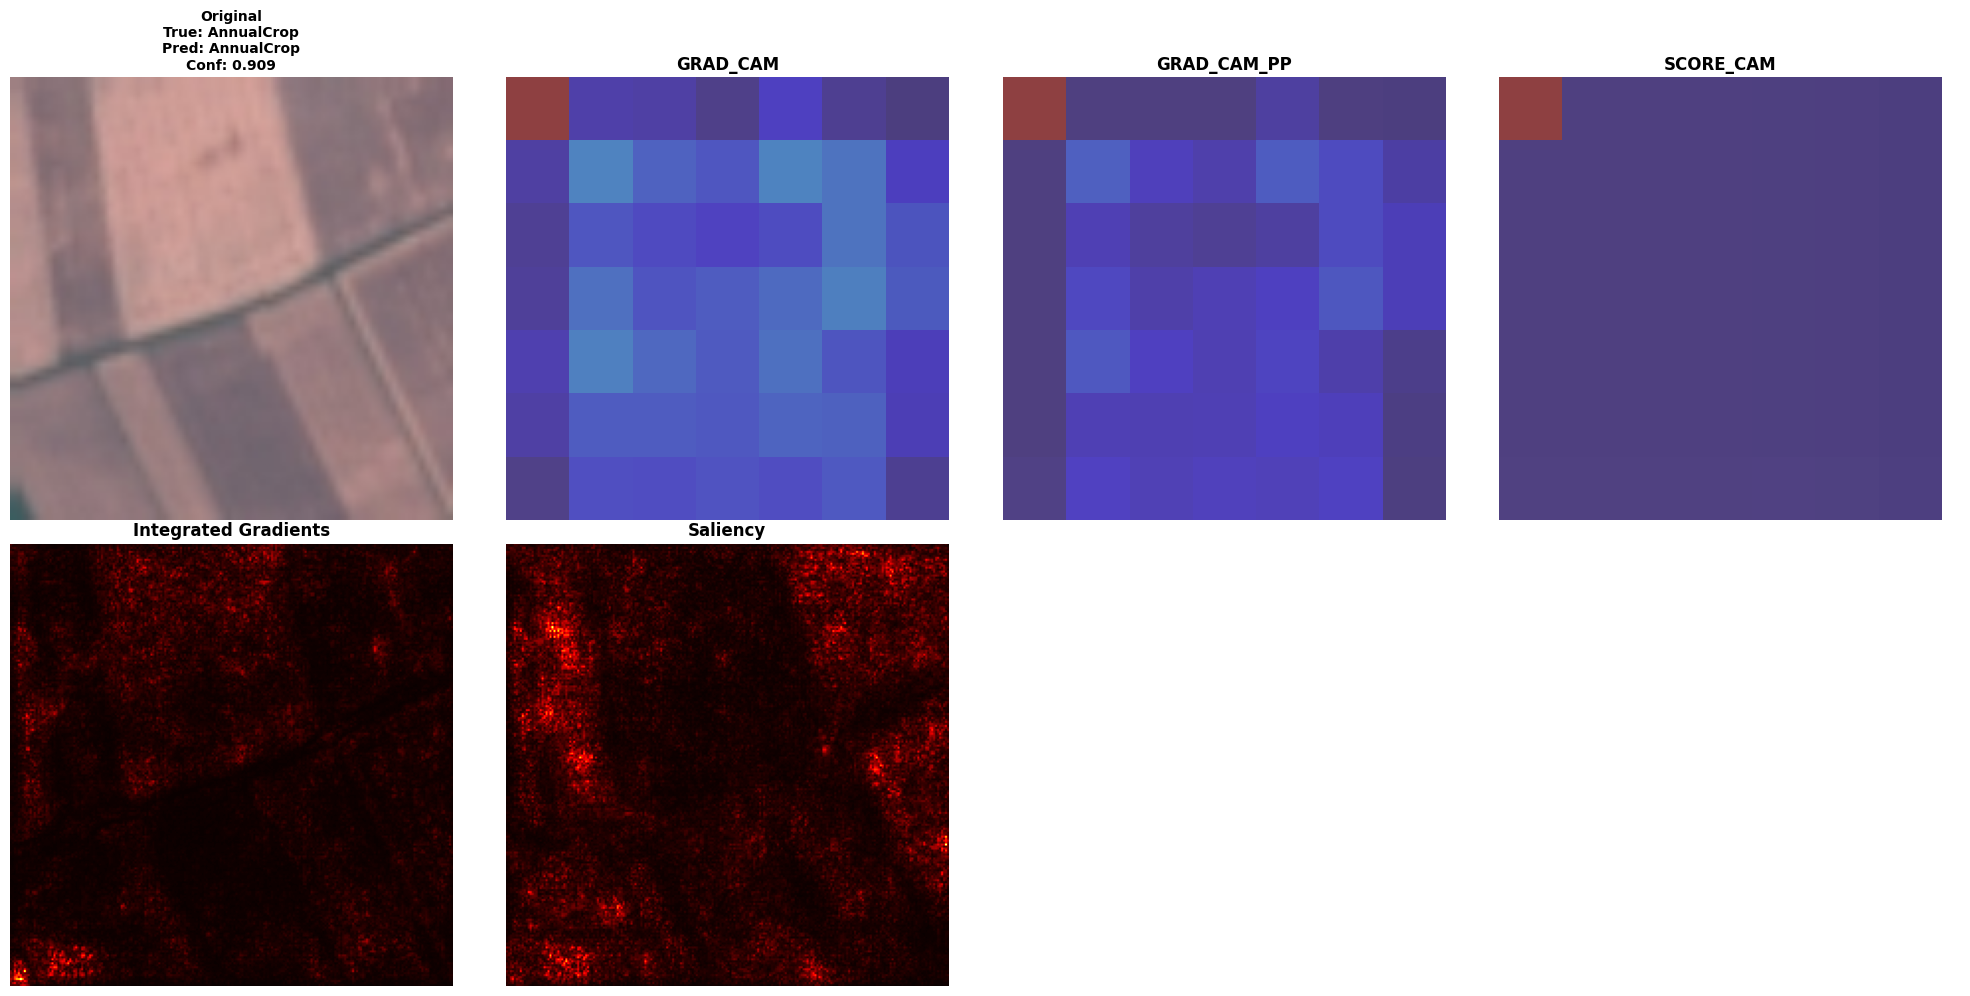

✅ CORRECT: Predicted AnnualCrop with 0.909 confidence

--- Sample 2: True Class = AnnualCrop ---


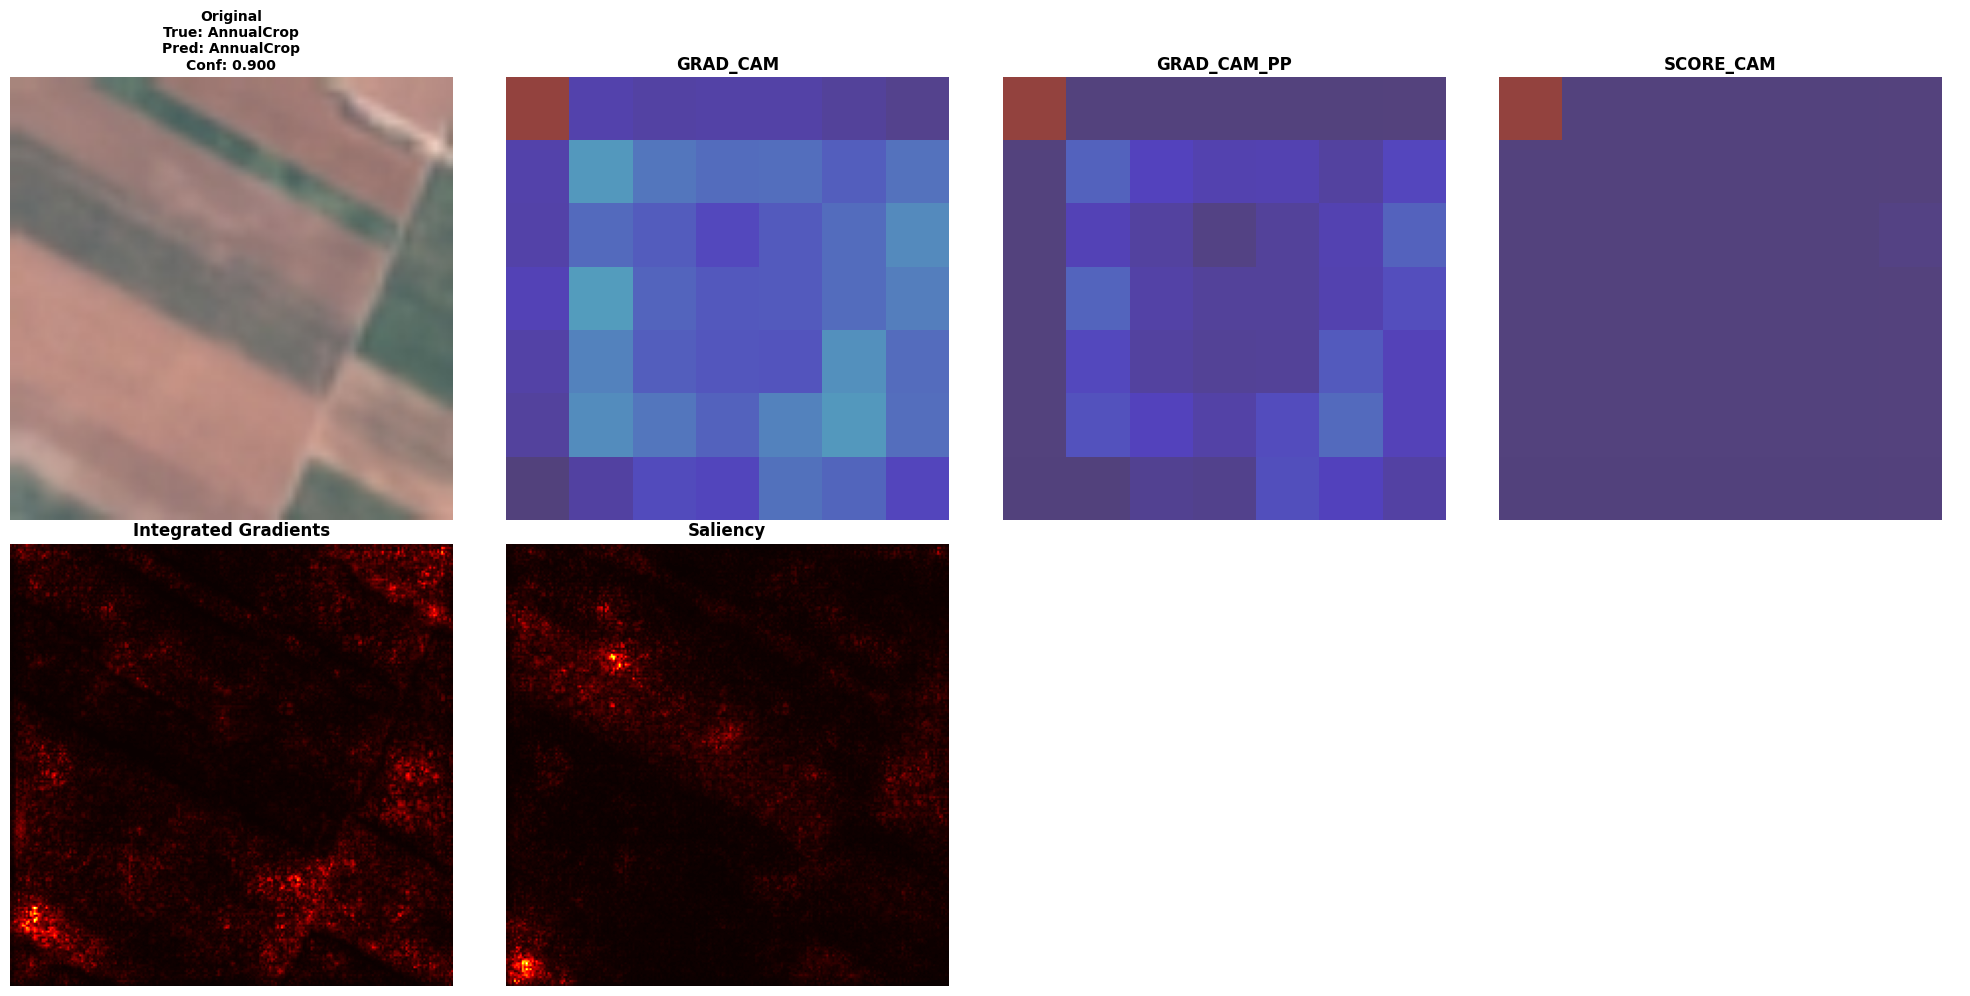

✅ CORRECT: Predicted AnnualCrop with 0.900 confidence

--- Sample 3: True Class = Residential ---


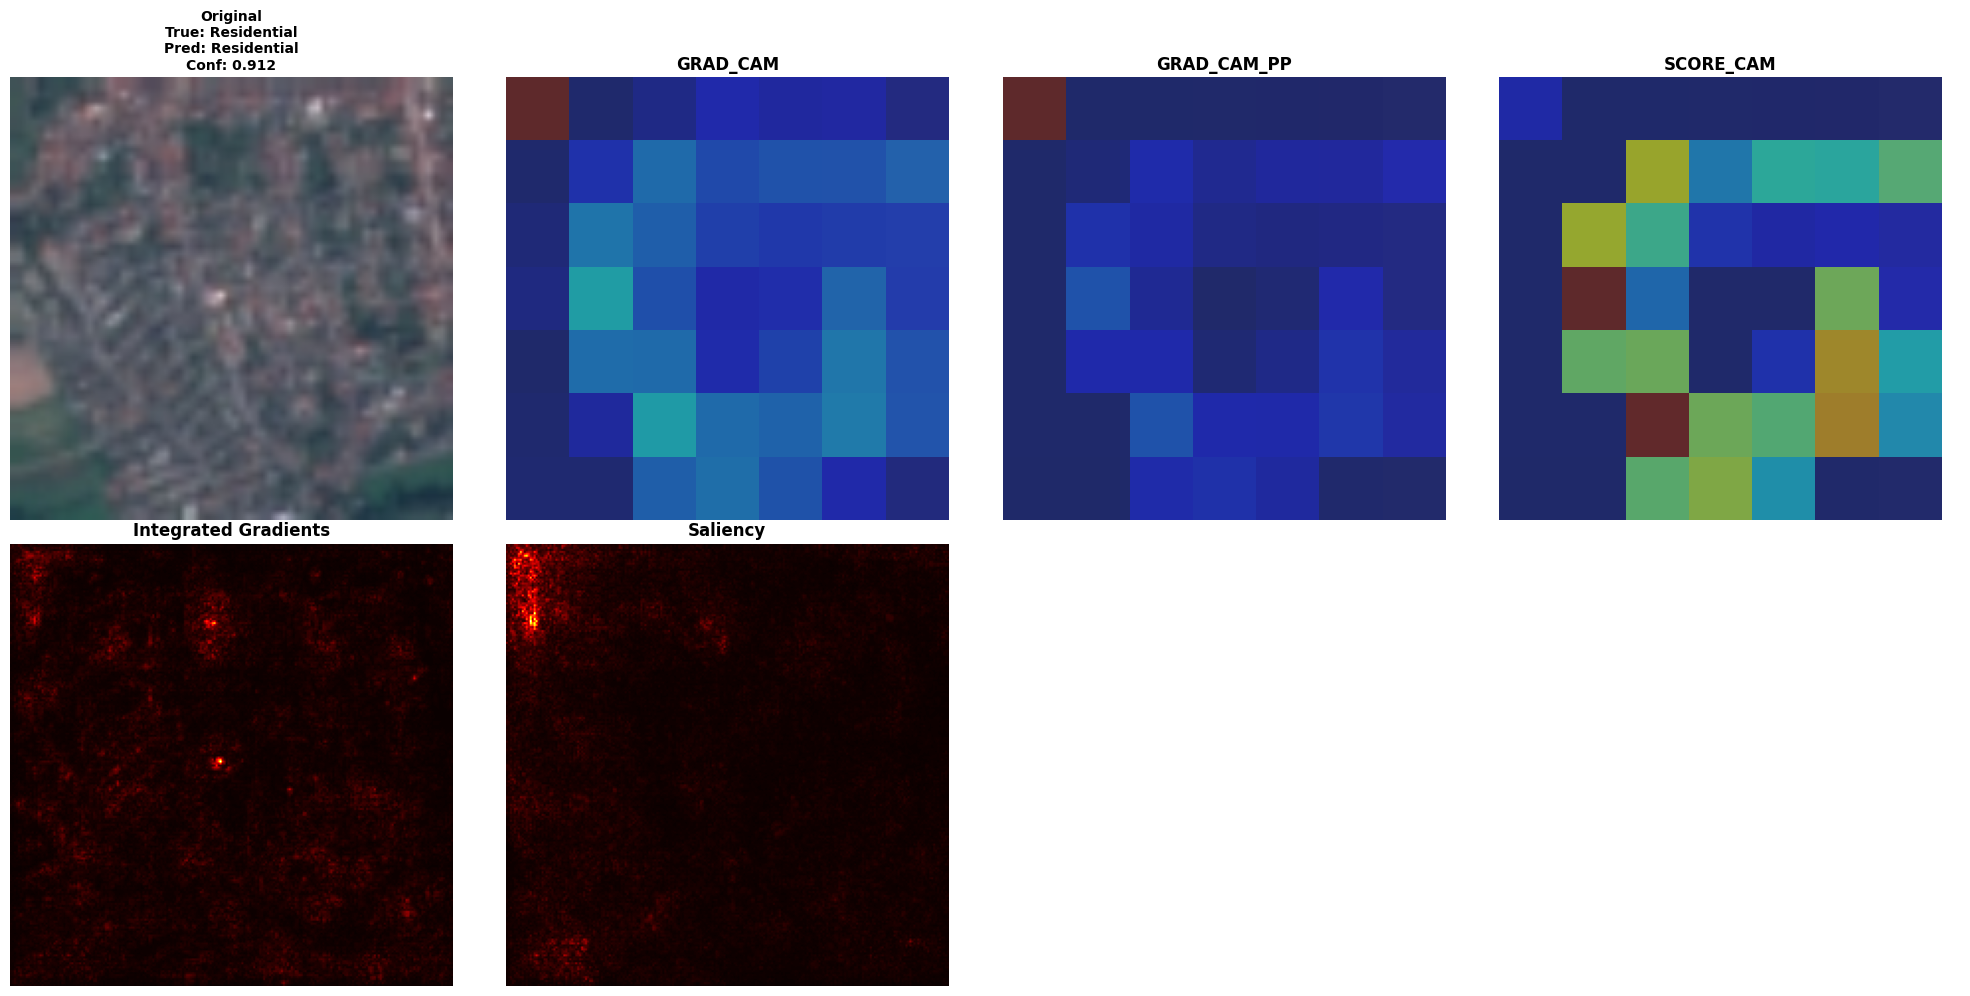

✅ CORRECT: Predicted Residential with 0.912 confidence

--- Sample 4: True Class = Forest ---


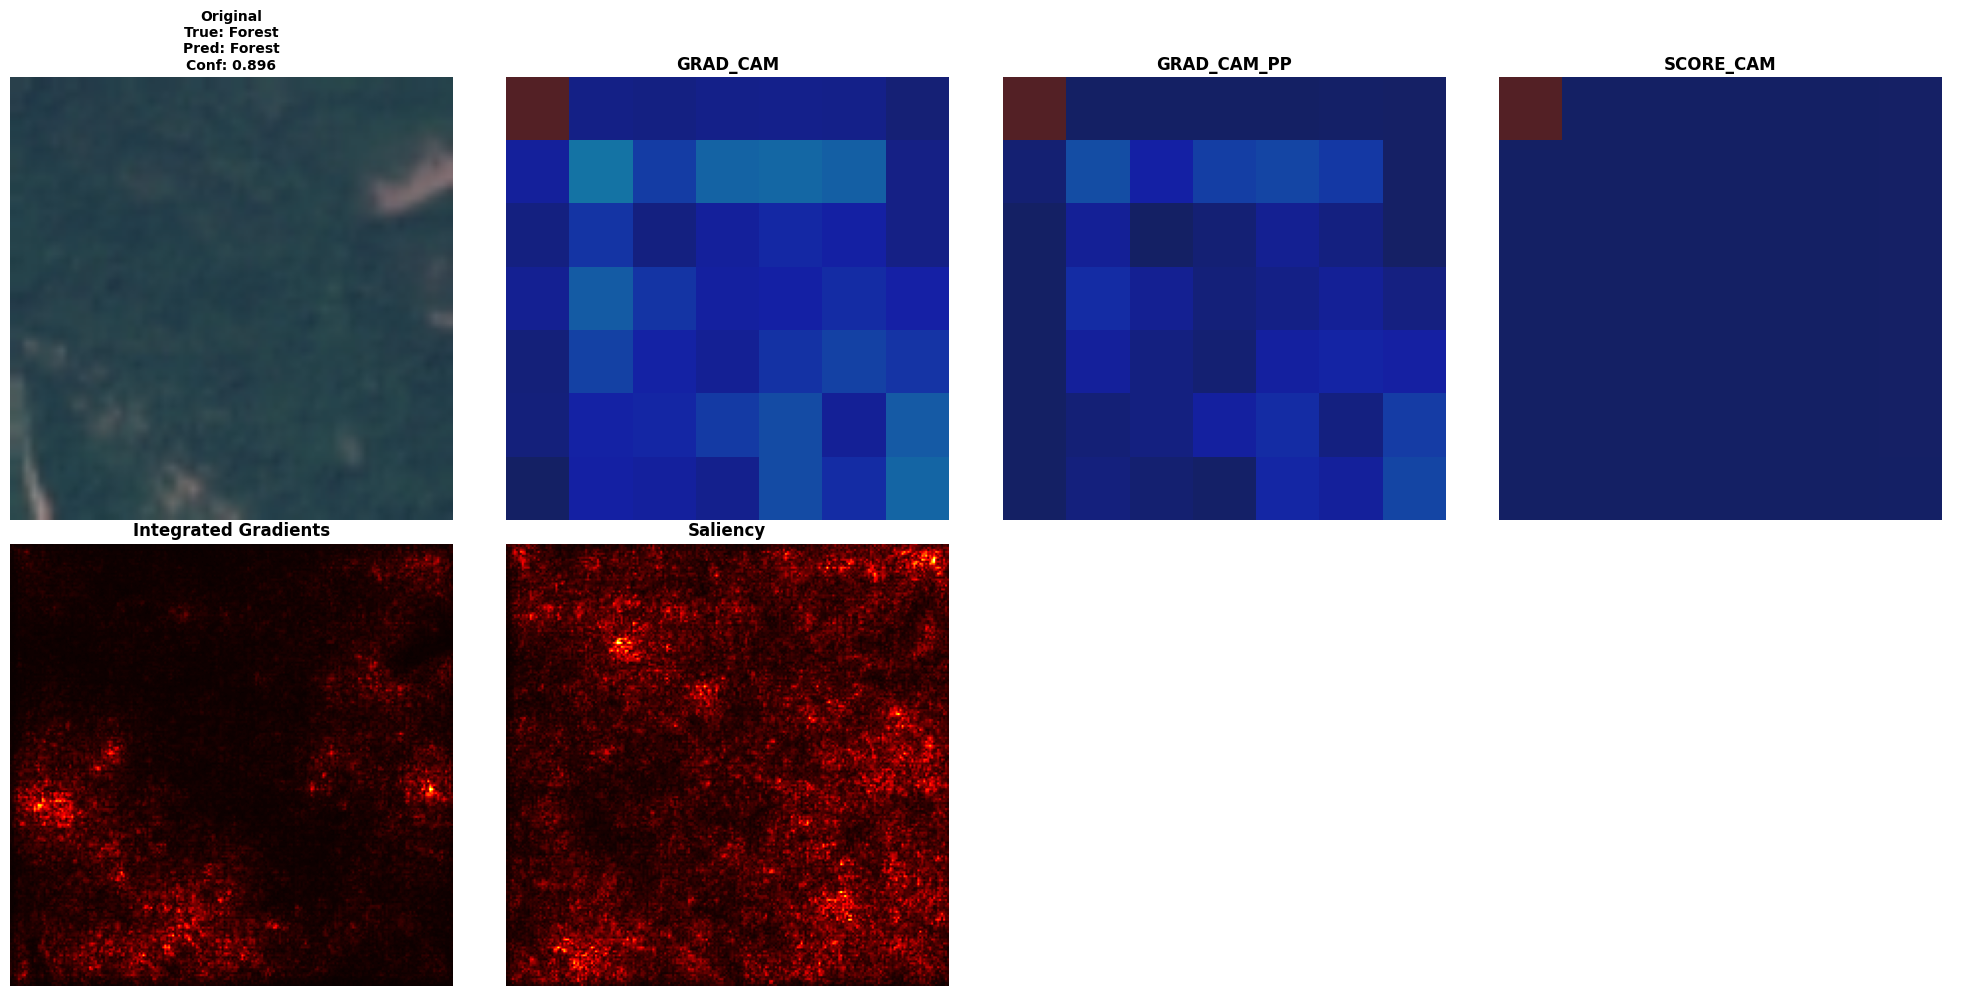

✅ CORRECT: Predicted Forest with 0.896 confidence

--- Sample 5: True Class = Residential ---


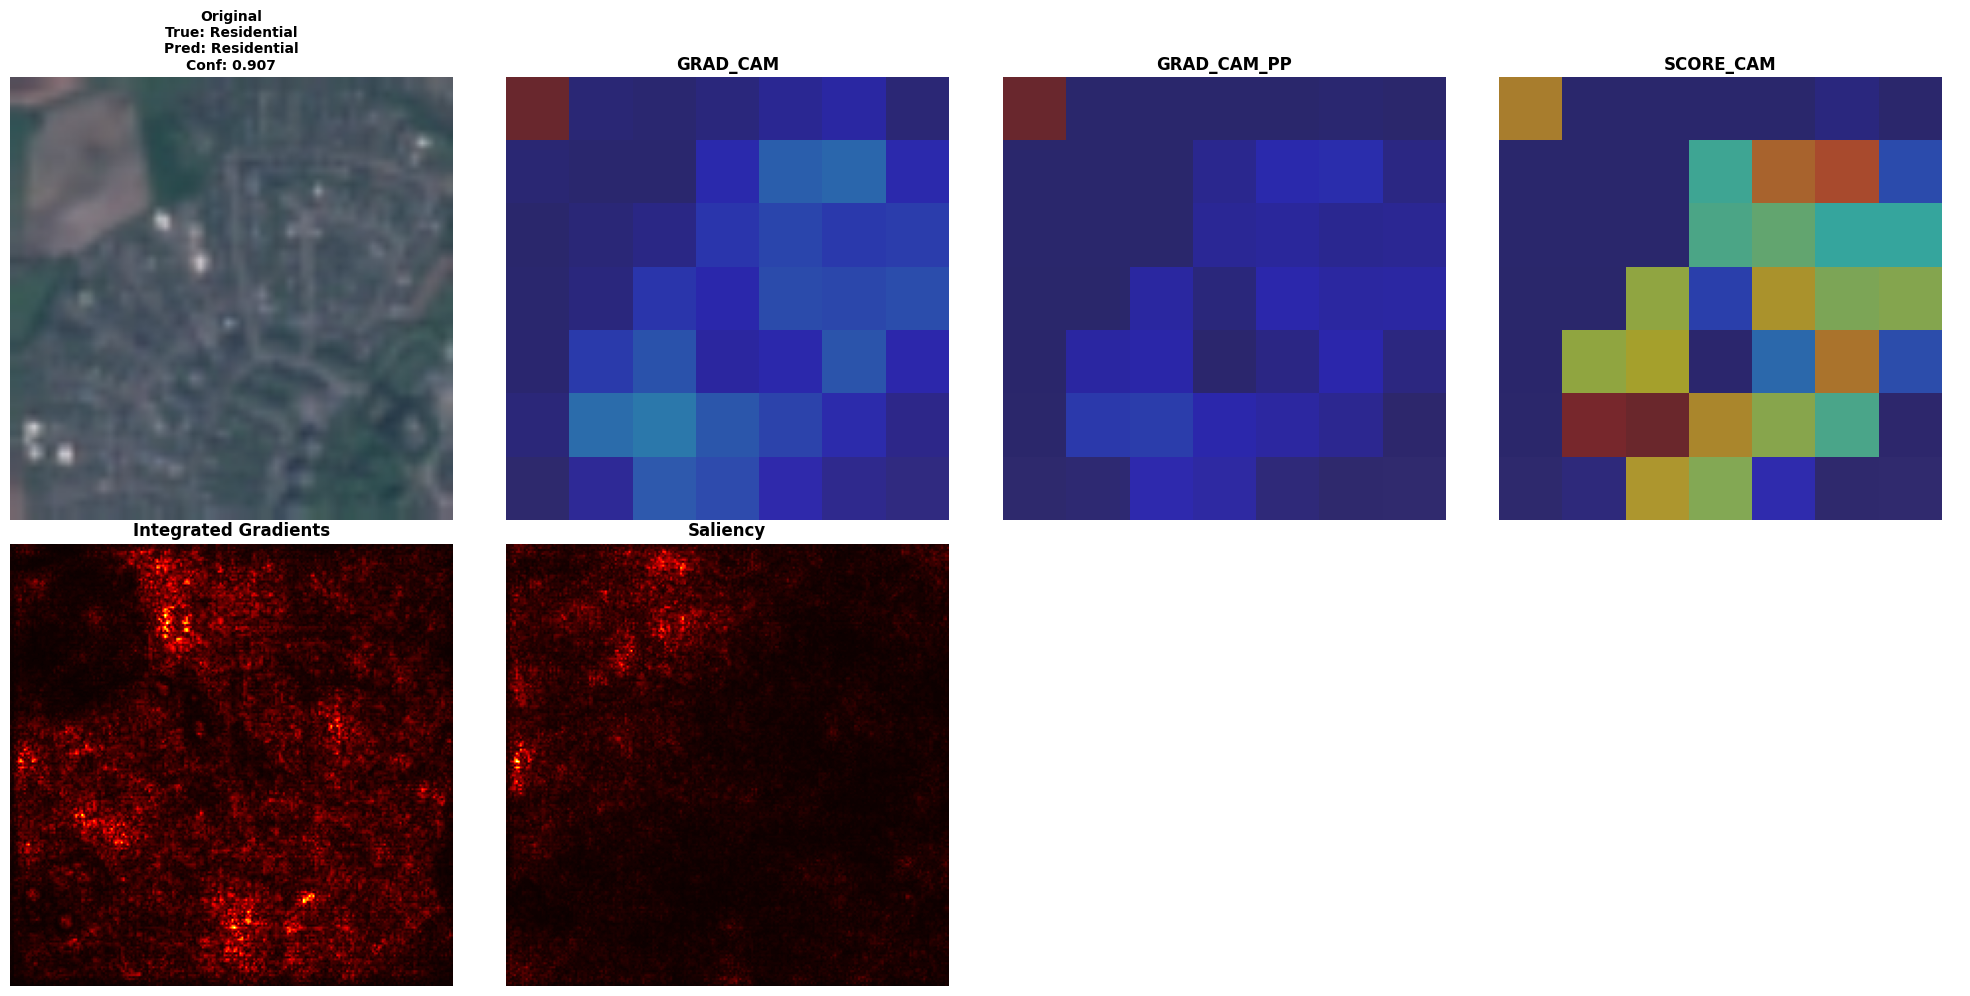

✅ CORRECT: Predicted Residential with 0.907 confidence


In [9]:
class MultiMethodXAI:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        
    def generate_explanations(self, image_tensor, target_class=None):
        """Generate multiple XAI explanations for a single image"""
        self.model.eval()
        image_tensor = image_tensor.unsqueeze(0).to(self.device)
        
        if target_class is None:
            with torch.no_grad():
                output = self.model(image_tensor)
                target_class = output.argmax(1).item()
                confidence = F.softmax(output, dim=1)[0, target_class].item()
        
        explanations = {}
        
        # Grad-CAM variants
        cam_methods = {
            'grad_cam': GradCAM,
            'grad_cam_pp': GradCAMpp,
            'score_cam': ScoreCAM,
        }
        
        target_layer = self._get_target_layer()
        if target_layer:
            for name, method in cam_methods.items():
                try:
                    with method(self.model, target_layer=target_layer) as extractor:
                        activation_map = extractor(target_class, self.model(image_tensor))
                        if activation_map is not None:
                            explanations[name] = activation_map[0].squeeze().cpu().numpy()
                except Exception as e:
                    print(f"Failed to generate {name}: {e}")
        
        # Captum methods
        try:
            explanations['integrated_gradients'] = self._integrated_gradients(image_tensor, target_class)
            explanations['saliency'] = self._saliency_map(image_tensor, target_class)
        except Exception as e:
            print(f"Failed to generate Captum explanations: {e}")
        
        return explanations, target_class, confidence
    
    def _get_target_layer(self):
        """Get the target layer for CAM methods based on model architecture"""
        if hasattr(self.model, 'features'):
            return self.model.features[-1]  # EfficientNet
        elif hasattr(self.model, 'layer4'):
            return self.model.layer4[-1]  # ResNet
        elif hasattr(self.model, 'models'):  # Ensemble
            return self.model.models[0].features[-1] if hasattr(self.model.models[0], 'features') else None
        else:
            return None
    
    def _integrated_gradients(self, image_tensor, target_class):
        """Generate Integrated Gradients attribution"""
        ig = IntegratedGradients(self.model)
        attributions = ig.attribute(image_tensor, target=target_class, n_steps=25)
        return attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    
    def _saliency_map(self, image_tensor, target_class):
        """Generate Saliency map"""
        saliency = Saliency(self.model)
        attributions = saliency.attribute(image_tensor, target=target_class)
        return attributions[0].cpu().detach().numpy().transpose(1, 2, 0)
    
    def visualize_explanations(self, original_image, explanations, true_label, pred_label, confidence, class_names):
        """Visualize all explanation methods"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        # Original image
        img_denorm = self.denormalize(original_image)
        axes[0].imshow(img_denorm)
        axes[0].set_title(f'Original\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.3f}', 
                         fontweight='bold', fontsize=10)
        axes[0].axis('off')
        
        # Each explanation method
        methods = list(explanations.keys())[:7]  # Show first 7 methods
        for idx, method in enumerate(methods):
            ax = axes[idx + 1]
            explanation = explanations[method]
            
            if method in ['integrated_gradients', 'saliency']:
                # For attribution methods
                self._plot_attribution(ax, img_denorm, explanation, method)
            else:
                # For CAM methods
                self._plot_cam(ax, img_denorm, explanation, method)
        
        # Hide unused subplots
        for idx in range(len(methods) + 1, 8):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_cam(self, ax, original_image, heatmap, method_name):
        """Plot CAM-based explanations"""
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        ax.imshow(original_image)
        ax.imshow(heatmap, alpha=0.5, cmap='jet')
        ax.set_title(f'{method_name.upper()}', fontweight='bold')
        ax.axis('off')
    
    def _plot_attribution(self, ax, original_image, attribution, method_name):
        """Plot attribution-based explanations"""
        attribution = np.mean(np.abs(attribution), axis=2)  # Convert to grayscale using absolute values
        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)
        ax.imshow(attribution, cmap='hot')
        ax.set_title(f'{method_name.replace("_", " ").title()}', fontweight='bold')
        ax.axis('off')
    
    def denormalize(self, tensor):
        """Denormalize image tensor for visualization"""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.permute(1, 2, 0).numpy()

    def analyze_multiple_samples(self, dataset, class_names, num_samples=5):
        """Generate XAI for multiple samples"""
        print(f"Generating XAI for {num_samples} samples...")
        
        for i in range(num_samples):
            sample_idx = i * 500  # Space out samples
            if sample_idx >= len(dataset):
                sample_idx = i * 100
                
            img, true_label = dataset[sample_idx]
            
            print(f"\n--- Sample {i+1}: True Class = {class_names[true_label]} ---")
            
            explanations, pred_label, confidence = self.generate_explanations(img)
            
            self.visualize_explanations(
                img, explanations, true_label, pred_label, confidence, class_names
            )
            
            # Print prediction info
            if true_label == pred_label:
                print(f"✅ CORRECT: Predicted {class_names[pred_label]} with {confidence:.3f} confidence")
            else:
                print(f"❌ INCORRECT: Predicted {class_names[pred_label]} (True: {class_names[true_label]}) with {confidence:.3f} confidence")

# Generate comprehensive XAI analysis
print("Starting Advanced XAI Analysis...")
xai_analyzer = MultiMethodXAI(model, config.DEVICE)
xai_analyzer.analyze_multiple_samples(val_dataset, class_names, num_samples=5)

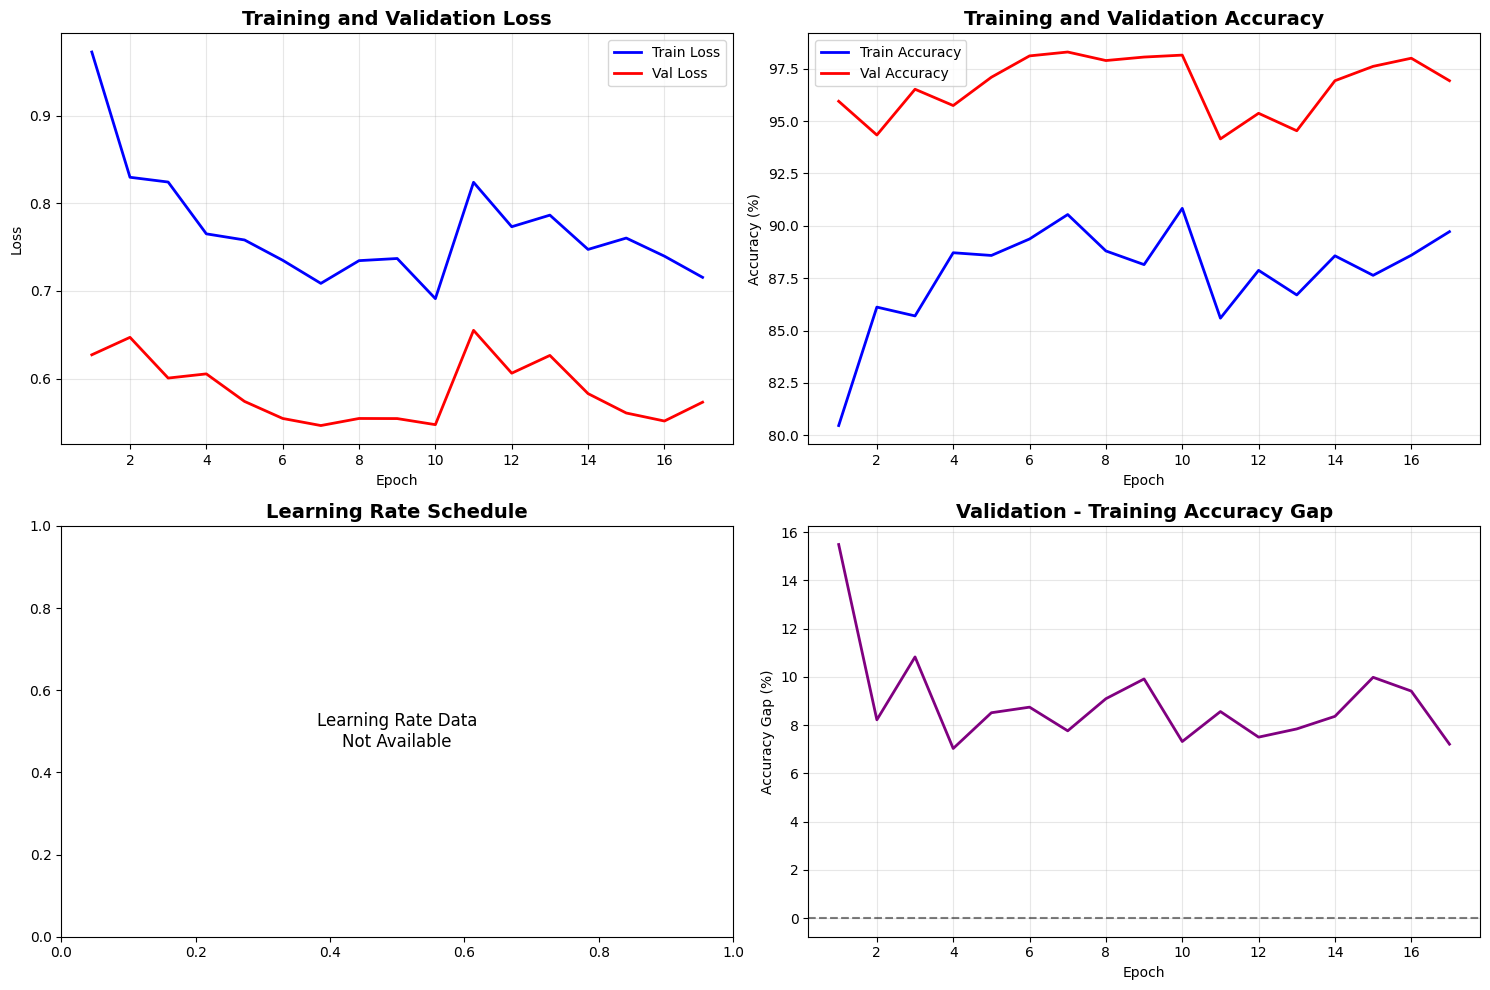


=== TRAINING SUMMARY ===
Final Training Accuracy: 89.72%
Final Validation Accuracy: 96.93%
Best Validation Accuracy: 98.30%
Final Training Loss: 0.7155
Final Validation Loss: 0.5730


In [10]:
def plot_comprehensive_training_history(history):
    """Plot comprehensive training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    if 'learning_rates' in history and history['learning_rates']:
        ax3.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate Data\nNot Available', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    
    # Performance gap plot
    if len(history['train_acc']) == len(history['val_acc']):
        performance_gap = [val - train for train, val in zip(history['train_acc'], history['val_acc'])]
        ax4.plot(epochs, performance_gap, 'purple', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_title('Validation - Training Accuracy Gap', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy Gap (%)')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final statistics
    print("\n=== TRAINING SUMMARY ===")
    print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

# Plot training history
plot_comprehensive_training_history(history)

In [12]:
def save_final_model(model, history, evaluation_results, class_names):
    """Save the final model and generate report"""
    # Save the best model
    model_path = '/kaggle/working/best_eurosat_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'history': history,
        'evaluation_results': evaluation_results,
        'timestamp': datetime.now().isoformat()
    }, model_path)
    
    print(f"Model saved to: {model_path}")
    
    # Generate final report
    print("\n" + "="*60)
    print("FINAL PROJECT REPORT")
    print("="*60)
    
    best_val_acc = max(history['val_acc'])
    final_val_acc = history['val_acc'][-1]
    
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Training Epochs: {len(history['train_loss'])}")
    
    if evaluation_results:
        eval_metrics = evaluation_results['standard_metrics']['classification_report']
        print(f"Test Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"Macro F1-Score: {eval_metrics['macro avg']['f1-score']:.4f}")
        print(f"Calibration ECE: {evaluation_results['confidence_calibration']['ece']:.4f}")
    
    print(f"Model Architecture: {'Ensemble' if config.USE_ENSEMBLE else config.MODEL_ARCH}")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Advanced Techniques: Label Smoothing, CutMix, Mixed Precision")
    print("="*60)

# Save final model and generate report
save_final_model(model, history, evaluation_results, class_names)

Model saved to: /kaggle/working/best_eurosat_model.pth

FINAL PROJECT REPORT
Best Validation Accuracy: 98.30%
Final Validation Accuracy: 96.93%
Training Epochs: 17
Test Accuracy: 0.9693
Macro F1-Score: 0.9688
Calibration ECE: 0.0940
Model Architecture: Ensemble
Batch Size: 64
Advanced Techniques: Label Smoothing, CutMix, Mixed Precision
